# RF vs XGBoost vs MLP on a (relatively small) CSV file

Dataset used: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report

In [129]:
df = pd.read_csv("diabetes.csv")
display(df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [130]:
x = df.drop(columns = ["Outcome"]).astype(float).values
y = df["Outcome"].values

In [131]:
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size = .2, shuffle = True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [133]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [134]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print(f'Train: {rf.score(x_train, y_train)}')
print(f'Validation: {rf.score(x_test, y_test)}')
print(f'OOB: {rf.oob_score_}')

Train: 1.0
Validation: 0.7467532467532467
OOB: 0.749185667752443


In [135]:
from sklearn.metrics import accuracy_score, confusion_matrix

Accuracy: 74.68%


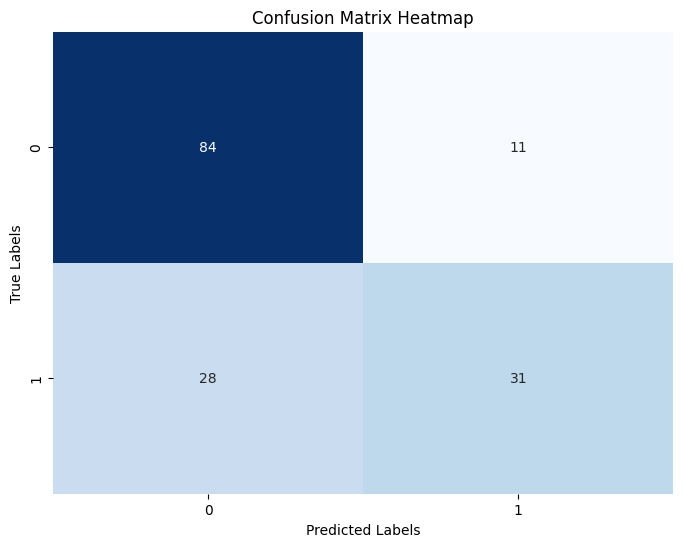

In [136]:
def plot_confusion_matrix(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
                xticklabels=["0", "1"], yticklabels=["0", "1"])
    
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

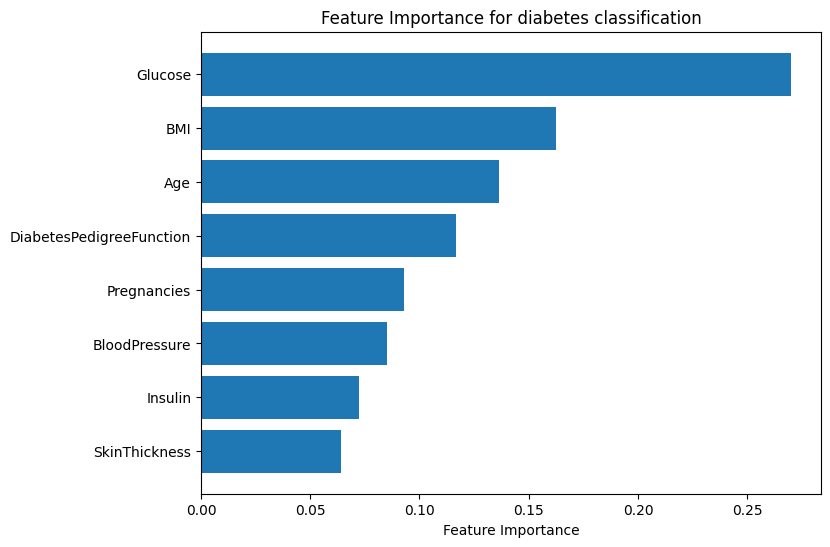

In [137]:
def plot_feature_importance(rf, df):
    feature_importances = rf.feature_importances_
    feature_names = df.drop(columns=["Outcome"]).columns
    
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    sorted_features = feature_names[sorted_indices]
    sorted_importances = feature_importances[sorted_indices]
    
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_features, sorted_importances)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for diabetes classification')
    plt.gca().invert_yaxis()  # Optional: most important feature at the top
    plt.show()

plot_feature_importance(rf, df)

In [138]:
print(classification_report(y_test, y_pred > .5, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.75      0.88      0.81        95
    positive       0.74      0.53      0.61        59

    accuracy                           0.75       154
   macro avg       0.74      0.70      0.71       154
weighted avg       0.75      0.75      0.74       154



In [143]:
xgb_rf = XGBClassifier(
    n_estimators=100,
    learning_rate=1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    booster='gbtree',
    use_label_encoder=False
)

xgb_rf.fit(x_train, y_train)
y_pred = xgb_rf.predict(x_test)

C:\Users\User\.conda\envs\ACLabs\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:32:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 69.48%


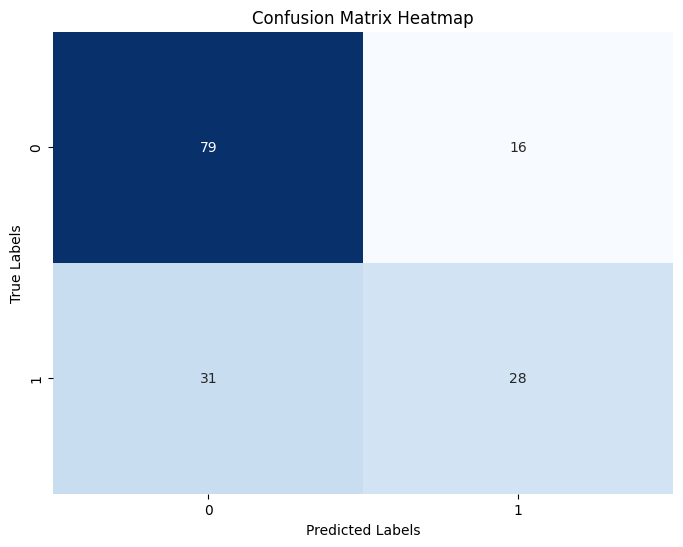

In [144]:
plot_confusion_matrix(y_test, y_pred)

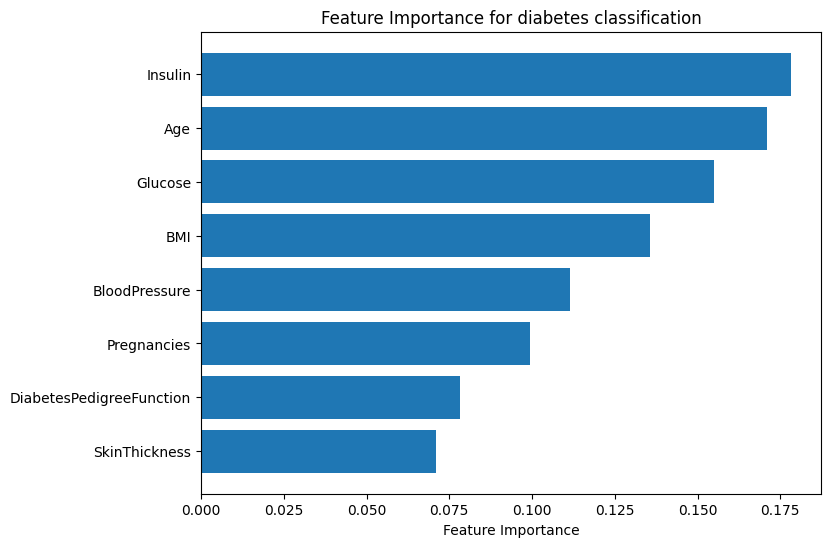

In [145]:
plot_feature_importance(xgb_rf, df)

In [146]:
print(classification_report(y_test, y_pred > .5, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.72      0.83      0.77        95
    positive       0.64      0.47      0.54        59

    accuracy                           0.69       154
   macro avg       0.68      0.65      0.66       154
weighted avg       0.69      0.69      0.68       154



In [147]:
model = Sequential()
model.add(Input(shape = x_train.shape[1:]))
model.add(Dense(units = 32, activation = "relu"))
model.add(Dense(units = 8, activation = "relu"))
model.add(Dense(units = 1, activation = "sigmoid"))

In [148]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 561 (2.19 KB)

 Trainable params: 561 (2.19 KB)

 Non-trainable params: 0 (0.00 B)

In [149]:
callbacks = []
callbacks.append(EarlyStopping(monitor='val_loss', patience=10))
callbacks.append(ModelCheckpoint('best_model.keras', monitor='val_acc',
                                                 save_weights_only=False, save_best_only=True))

In [150]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [151]:
history = model.fit(x=x_train, y=y_train, validation_split=.25, batch_size=32, callbacks=callbacks, epochs=100)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - binary_accuracy: 0.7005 - loss: 0.6167 - val_binary_accuracy: 0.6818 - val_loss: 0.6274
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6409 - loss: 0.6185 - val_binary_accuracy: 0.6948 - val_loss: 0.6042
Epoch 3/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - binary_accuracy: 0.6562 - loss: 0.5735

C:\Users\User\.conda\envs\ACLabs\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6746 - loss: 0.5674 - val_binary_accuracy: 0.6883 - val_loss: 0.5870
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6774 - loss: 0.5338 - val_binary_accuracy: 0.7013 - val_loss: 0.5746
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7033 - loss: 0.5279 - val_binary_accuracy: 0.7273 - val_loss: 0.5659
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7331 - loss: 0.5029 - val_binary_accuracy: 0.7273 - val_loss: 0.5587
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7572 - loss: 0.4758 - val_binary_accuracy: 0.7338 - val_loss: 0.5522
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7714 - loss: 0.4851 - val_binary_accuracy: 0.7338 - val_loss: 0.5483
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7758 - loss: 0.4692 - val_binary_accuracy: 0.7403 - val_loss: 0.5431
Epoch 10/100
15/15 ━━━━━━

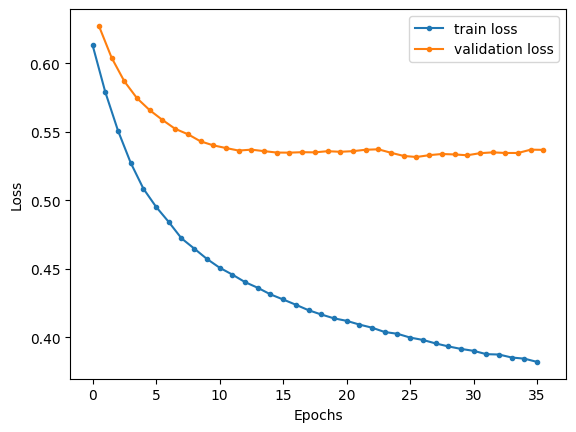

In [152]:
epochs = np.array(history.epoch)

plt.plot(epochs,      history.history['loss'],     label='train loss',      marker='.')
plt.plot(epochs + .5, history.history['val_loss'], label='validation loss', marker='.')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

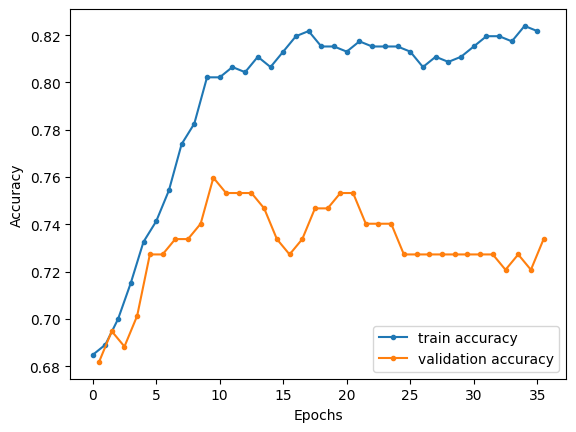

In [153]:
plt.plot(epochs,      history.history['binary_accuracy'],     label='train accuracy',      marker='.')
plt.plot(epochs + .5, history.history['val_binary_accuracy'], label='validation accuracy', marker='.')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [154]:
y_pred = model.predict(x_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Accuracy: 74.68%


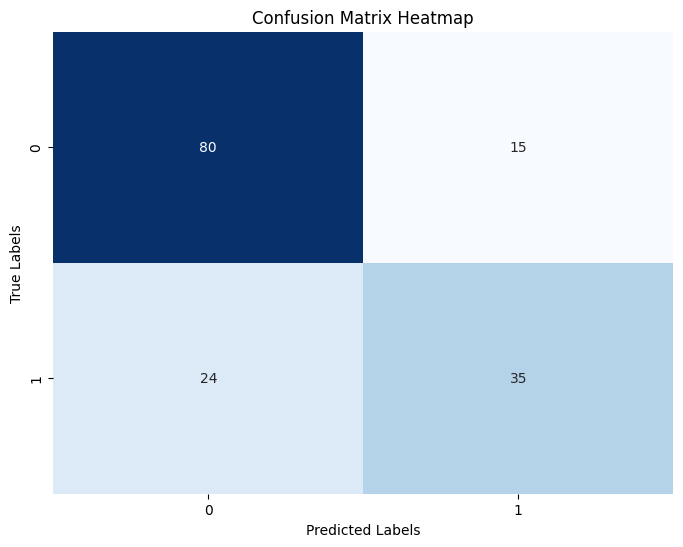

In [155]:
plot_confusion_matrix(y_test, y_pred_binary)

In [156]:
print(classification_report(y_test, y_pred > .5, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.77      0.84      0.80        95
    positive       0.70      0.59      0.64        59

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.74      0.75      0.74       154



A few conclusions: 
- all 3 of the models struggle to classify 1-labeled entries, probably due to them being much less than those labeled 0
- on such a small dataset, all of the models perform roughly the same, regarding accuracy, precision, recall and f1-score
- interesting to see the difference in feature importance between the classic RF and the XGBoost RF, but also interesting to see which common features are most/least important
- would be interesting to see the differences on a much larger and equally labeled dataset